## **Setup + Introduction**

In [25]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers as lyrs, optimizers as opts, activations as acts, losses as ls

import matplotlib.pyplot as plt


## **Training, evaluation, and inference**

>> **The main idea is that a deep learning model is usually a directed acyclic graph (DAG) of layers. So the functional API is a way to build `graphs of layers`.**

In [2]:
'''
    Creating a Linear totplogy using functional layer!!
    Topology:
        Inputs([784]) => Dense(units= 64, 'relu') => Dense(units= 32, 'relu') => Dense(units= 10, 'softmax')
'''

inp = tfk.Input(shape=[784], name='Input_Layer')
d1 = lyrs.Dense(128, 'relu', name= 'Dense_1')(inp)
d2 = lyrs.Dense(64, 'relu', name= 'Dense_2')(d1)
out = lyrs.Dense(10, 'softmax', name= 'OutputLayer')(d2)


model = tfk.Model(inputs= inp, outputs= out, name='Classification_Model')
model.summary()


Model: "Classification_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None, 784)]             0         
                                                                 
 Dense_1 (Dense)             (None, 128)               100480    
                                                                 
 Dense_2 (Dense)             (None, 64)                8256      
                                                                 
 OutputLayer (Dense)         (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [5]:
tfk.utils.plot_model(model, to_file='model.png', show_shapes= True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [67]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

'''
    1. Preparing data
    2. Building the Model
    3. Train and evaluate 
'''

dataset = tfk.datasets.mnist
(tr_data, tr_lbls), (ts_data, ts_lbls) = dataset.load_data()

# We Flatten the incoming tensor, to convert its dimensions from [28, 28] to (28 x 28)
# We use astype to change type of data

print(tr_data.shape)
print(tr_data.dtype)

tr_data = lyrs.Flatten()(tr_data).astype('float32') / 255.0
ts_data = ts_data.reshape(-1,784).astype('float32') / 255.0

print(ts_data.shape)
print(tr_data.dtype)



(60000, 28, 28)
uint8
(10000, 784)
<dtype: 'float32'>


In [24]:
model.compile(
    optimizer= opts.Adam(learning_rate= 0.005),
    loss= ls.SparseCategoricalCrossentropy(),
    metrics= ['accuracy']
)

his = model.fit(
    tr_data,
    tr_lbls,
    validation_split=0.25,
    batch_size=64,
    epochs=100,
    verbose=1
)

Epoch 1/100
704/704 [==============================] - 6s 6ms/step - loss: 0.2445 - accuracy: 0.9258 - val_loss: 0.1422 - val_accuracy: 0.9565
Epoch 2/100
704/704 [==============================] - 3s 5ms/step - loss: 0.1184 - accuracy: 0.9642 - val_loss: 0.1239 - val_accuracy: 0.9620
Epoch 3/100
704/704 [==============================] - 3s 5ms/step - loss: 0.0884 - accuracy: 0.9727 - val_loss: 0.1263 - val_accuracy: 0.9649
Epoch 4/100
704/704 [==============================] - 4s 6ms/step - loss: 0.0822 - accuracy: 0.9753 - val_loss: 0.1294 - val_accuracy: 0.9667
Epoch 5/100
704/704 [==============================] - 4s 6ms/step - loss: 0.0614 - accuracy: 0.9800 - val_loss: 0.1289 - val_accuracy: 0.9679
Epoch 6/100
704/704 [==============================] - 4s 6ms/step - loss: 0.0589 - accuracy: 0.9820 - val_loss: 0.1320 - val_accuracy: 0.9673
Epoch 7/100
704/704 [==============================] - 4s 6ms/step - loss: 0.0520 - accuracy: 0.9836 - val_loss: 0.1496 - val_accuracy: 0.9657

In [51]:


def plot_history(history, metric):
    r = len(history[metric])
    plt.plot(history[metric], label='Training')
    plt.plot(history['val_'+ metric], label='Validation')
    plt.title(metric)
    
    if metric == 'loss':
        plt.ylim([0, 1])
    else:
        plt.ylim([0.9, 1.0])
    plt.legend()
        

history = his.history
print(history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


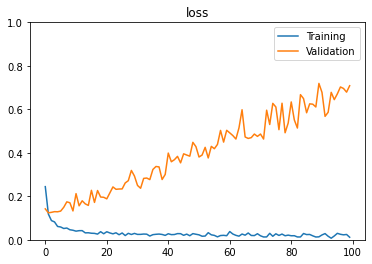

In [52]:

plot_history(history, 'loss')


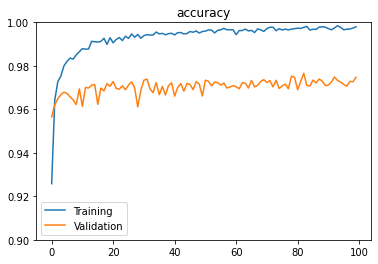

In [53]:

plot_history(history, 'accuracy')


## **Save and serialize**
**The standard way to save a functional model is to call model.save() to save the entire model as a single file. You can later recreate the same model from this file, even if the code that built the model is no longer available.**

> **`The Saved Model includes:`**
1. **Model Architecture**
2. **Model Weights**
3. **Model training config**
4. **Optimizer and its state**

In [72]:
# # save Model
# model.save('SavedModel')

# # delete existing model
# del model

# Reloading Model
model_loaded = tfk.models.load_model('SavedModel')
pred = model_loaded(ts_data[:10])


tf.nn.softmax(pred)
for i in pred:
    print(np.argmax(i))
    

7
2
1
0
4
1
4
9
6
9


## **Reusing graph of layers to define multiple**

In [98]:
# First we will create an Encoder by stacking layers.
# Then, we will reuse the existing layers graph to instantiate new model that decodes the encoder-output.

encoder_inp = lyrs.Input((28, 28, 1), name='InputLayer')
x = lyrs.Conv2D(128, 3, activation='relu')(encoder_inp)
x = lyrs.Conv2D(64, 3, activation='relu')(x)
x = lyrs.MaxPooling2D(3)(x)
x = lyrs.Conv2D(32, 3, activation='relu')(x)
x = lyrs.Conv2D(16, 3, activation='relu')(x)
encoder_out = lyrs.GlobalMaxPooling2D()(x)

model_encoder = tfk.Model(encoder_inp, encoder_out, name='Encoder')
model_encoder.summary()


Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 26, 26, 128)       1280      
                                                                 
 conv2d_25 (Conv2D)          (None, 24, 24, 64)        73792     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_26 (Conv2D)          (None, 6, 6, 32)          18464     
                                                                 
 conv2d_27 (Conv2D)          (None, 4, 4, 16)          4624      
                                                           

In [99]:
# Now creating the decoder!!
autoencoder_inp = lyrs.Reshape((4, 4, 1))(encoder_out)
x = lyrs.Conv2DTranspose(128, 3, activation='relu')(autoencoder_inp)
x = lyrs.Conv2DTranspose(64, 3, activation='relu')(x)
x = lyrs.UpSampling2D(3)(x)
x = lyrs.Conv2DTranspose(32, 3, activation='relu')(x)
autoencoder_out = lyrs.Conv2DTranspose(1, 3, activation='relu')(x)

model_autoencoder = tfk.Model(encoder_inp, autoencoder_out, name='autoencoder')
model_autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 26, 26, 128)       1280      
                                                                 
 conv2d_25 (Conv2D)          (None, 24, 24, 64)        73792     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_26 (Conv2D)          (None, 6, 6, 32)          18464     
                                                                 
 conv2d_27 (Conv2D)          (None, 4, 4, 16)          4624      
                                                       

## **Callable Models, just like layers**

> **Treating `NeuralNet-Models` like `KerasLayers` allows us to design modular-Models, which can take in any specific input and produce an output. Models can also be combined||stacked like layers to form pipelines(Model architecture)**

In [134]:
"""
    In this part, we are going to form a autoencoder by 
    first creating seperate encoders and decoders, then chaining them together 
    to form autoencoder architecture
"""

Encoder_Inp = tfk.Input(shape=(150, 150, 1), name='Encoded_Image')
lyr = lyrs.Conv2D(256, 3, activation='relu')(Encoder_Inp)
lyr = lyrs.Conv2D(256, 3, activation='relu')(lyr)
lyr = lyrs.Conv2D(256, 3, activation='relu')(lyr)
lyr = lyrs.MaxPooling2D(3)(lyr)

lyr = lyrs.Conv2D(128, 3, activation='relu')(lyr)
lyr = lyrs.Conv2D(128, 3, activation='relu')(lyr)
lyr = lyrs.MaxPooling2D(2)(lyr)

lyr = lyrs.Conv2D(64, 3, activation='relu')(lyr)
lyr = lyrs.Conv2D(32, 3, activation='relu')(lyr)
lyr = lyrs.Conv2D(16, 3, activation='relu')(lyr)
lyr = lyrs.MaxPooling2D(3)(lyr)
Encoder_Out = lyrs.GlobalMaxPooling2D()(lyr)

ModelEncoder = tfk.Model(Encoder_Inp, Encoder_Out, name='Encoder')
ModelEncoder.summary()


Decoder_Inp = tfk.Input(shape=(25, ), name='Encoded_Image')
lyr = lyrs.Reshape((5, 5, 1))(Decoder_Inp)
lyr = lyrs.UpSampling2D(3)(lyr)

lyr = lyrs.Conv2DTranspose(16, 2, activation='relu')(lyr)
lyr = lyrs.Conv2DTranspose(32, 3, activation='relu')(lyr)
lyr = lyrs.Conv2DTranspose(64, 3, activation='relu')(lyr)
lyr = lyrs.Conv2DTranspose(64, 3, activation='relu')(lyr)
lyr = lyrs.UpSampling2D(2)(lyr)

lyr = lyrs.Conv2DTranspose(128, 3, activation='relu')(lyr)
lyr = lyrs.Conv2DTranspose(128, 3, activation='relu')(lyr)
lyr = lyrs.UpSampling2D(3)(lyr)

lyr = lyrs.Conv2DTranspose(64, 3, activation='relu')(lyr)
lyr = lyrs.Conv2DTranspose(64, 3, activation='relu')(lyr)
output = lyrs.Conv2DTranspose(1, 3, activation='relu')(lyr)

ModelDecoder = tfk.Model(Decoder_Inp, output, name='Decoder')
ModelDecoder.summary()

autoenc_inp = tfk.Input((150, 150, 1), name='AutoEncoder_Input')

encoded_image = ModelEncoder(autoencoder_inp)
decoded_image = ModelDecoder(encoded_image)

autoencoder = tfk.Model(autoenc_inp, decoded_image, name='AutoEncoder')
autoencoder.summary()

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoded_Image (InputLayer)  [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_232 (Conv2D)         (None, 148, 148, 256)     2560      
                                                                 
 conv2d_233 (Conv2D)         (None, 146, 146, 256)     590080    
                                                                 
 conv2d_234 (Conv2D)         (None, 144, 144, 256)     590080    
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 48, 48, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_235 (Conv2D)         (None, 46, 46, 128)       295040    
                                                           

ValueError: Exception encountered when calling layer "conv2d_233" (type Conv2D).

Negative dimension size caused by subtracting 3 from 2 for '{{node Encoder/conv2d_233/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](Encoder/conv2d_232/Relu, Encoder/conv2d_233/Conv2D/ReadVariableOp)' with input shapes: [?,2,2,256], [3,3,256,256].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 2, 2, 256), dtype=float32)

In [133]:
encoder_input = tfk.Input(shape=(28, 28, 1), name="original_img")
x = lyrs.Conv2D(16, 3, activation="relu")(encoder_input)
x = lyrs.Conv2D(32, 3, activation="relu")(x)
x = lyrs.MaxPooling2D(3)(x)
x = lyrs.Conv2D(32, 3, activation="relu")(x)
x = lyrs.Conv2D(16, 3, activation="relu")(x)
encoder_output = lyrs.GlobalMaxPooling2D()(x)

encoder = tfk.Model(encoder_input, encoder_output, name="encoder")
encoder.summary()

decoder_input = tfk.Input(shape=(16,), name="encoded_img")
x = lyrs.Reshape((4, 4, 1))(decoder_input)
x = lyrs.Conv2DTranspose(16, 3, activation="relu")(x)
x = lyrs.Conv2DTranspose(32, 3, activation="relu")(x)
x = lyrs.UpSampling2D(3)(x)
x = lyrs.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = lyrs.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = tfk.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

autoencoder_input = tfk.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = tfk.Model(autoencoder_input, decoded_img, name="autoencoder")
autoencoder.summary()


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 original_img (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_228 (Conv2D)         (None, 26, 26, 16)        160       
                                                                 
 conv2d_229 (Conv2D)         (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_78 (MaxPoolin  (None, 8, 8, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_230 (Conv2D)         (None, 6, 6, 32)          9248      
                                                                 
 conv2d_231 (Conv2D)         (None, 4, 4, 16)          4624      
                                                           

## **Manipulate complex graph topologies**

> #### **Multi Input||Outputs**

> #### **Mini Resnet**

## **Shared Layers**

## **Extract and reuse Nodes in graph of layers**

## **Extend the Func-API using custom-layers**

## **Practical Use**

> #### **Strengths**

> #### **Weaknesses**

## **Mix n Match API styles**